In [3]:
using SCPToolbox, Plots, LinearAlgebra, DifferentialEquations
include("../../Guidance/src/Quaternions.jl")


(process:9196): GLib-GIO-WARNING **: 14:52:06.792: Unexpectedly, UWP app `61252GDSoftware.EasyPosterPrinter_8.0.0.0_neutral__8gw22ntmsa2nc' (AUMId `61252GDSoftware.EasyPosterPrinter_8gw22ntmsa2nc!App') supports 1 extensions but has no verbs


to_matrix (generic function with 1 method)

In [4]:
include("Parameters.jl")

Rocket = RocketStruct();

In [5]:
include("Atmosphere.jl")

atmos = atmosphere()

atmosphere
  gravity: #16 (function of type var"#16#20")
  density: density (function of type typeof(UnitSystems.density))
  speedOfSound: sonicspeed (function of type typeof(sonicspeed))
  kinematicViscocity: kinematic (function of type typeof(kinematic))


In [6]:
module scp_new_problem
include("../../Guidance/src/6dof fixed t_burn udotdot.jl")
end # module

using .scp_new_problem

In [7]:
solution = scp_new_problem.solve(:ptr); # Remember J is augmented cost function

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 1e-01 | 0e+00 | 6e-09 | 9.26e+00  |           | 8e-02 | 4e-01 | 2e-01 | 2e-01 | T   | 0.13  | 0.41  | 0.16 


2  | ALMOST_O | 5e-04 | 0e+00 | 6e-09 | 3.58e-01  | 96.14     | 1e-02 | 3e-01 | 3e-02 | 4e-02 | T   | 0.05  | 0.28  | 0.03 


3  | ALMOST_O | 3e-04 | 0e+00 | 2e-08 | 2.81e-01  | 21.36     | 5e-03 | 3e-01 | 7e-04 | 6e-03 | T   | 0.10  | 0.28  | 0.00 


4  | ALMOST_O | 8e-06 | 0e+00 | 3e-08 | 2.79e-01  | 0.99      | 2e-03 | 2e-01 | 4e-05 | 2e-03 | T   | 0.03  | 0.17  | 0.00 


5  | ALMOST_O | 4e-06 | 0e+00 | 2e-08 | 2.78e-01  | 0.09      | 1e-03 | 2e-01 | 3e-05 | 1e-03 | T   | 0.04  | 0.19  | 0.00 


3.508428645587324


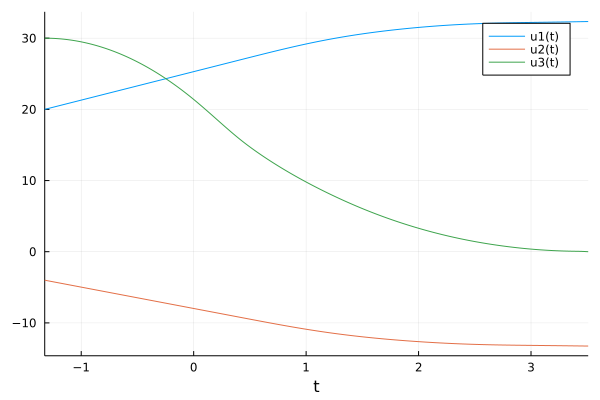

In [8]:
include("Aerodynamics.jl")

function f!(dx, x, p, t)
    r = x[1:3]
    height = r[3]
    v = x[4:6]
    quat = x[7:10]
    ω = x[11:13]
    T = x[14:16]
    Ṫ = x[17:19]

    rocket, atmos, solution, wind = p

    if 0 ≤ t ≤ rocket.BurnTime
        Control = sample(solution.uc, t / rocket.BurnTime) # if false, false
    else
        Control = zeros(4)
    end

    dx[1:3] = v
    dx[4:6] = atmos.gravity(height) + rotate(quat, T) * rocket.Acceleration(t)
    dx[7:10] = 1/2 * quatL(quat) * [0; ω]
    dx[11:13] = rocket.InertiaTensor \ ([0; 0; -rocket.COTToCG(t)] × T * rocket.Thrust(t) + [0; 0; Control[4]] - cross(ω, rocket.InertiaTensor * ω))
    dx[14:16] = Ṫ
    dx[17:19] = Control[1:3]

    CalculateAero!(dx[4:6], dx[11:13], rocket, atmos, wind, v, quat, ω, height, t)
end

r_0 = [20; -4; 30];	# position vector, m
v_0 = [4; -3; 0];		# velocity vector, m/s
q_0 = [1; 0; 0; 0];
w_0 = [0; 0; 0]
T_0 = [0; 0; 1] # acceleration from Thrust normalised
Tdot_0 = [0; 0; 0]

prob = ODEProblem(f!, float([r_0; v_0; q_0; w_0; T_0; Tdot_0]), (-solution.p[1], Rocket.BurnTime + 1.0), (Rocket, atmos, solution, randn(3) * 5))

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

println(sol.t[end])
Plots.plot(sol, vars=1:3)

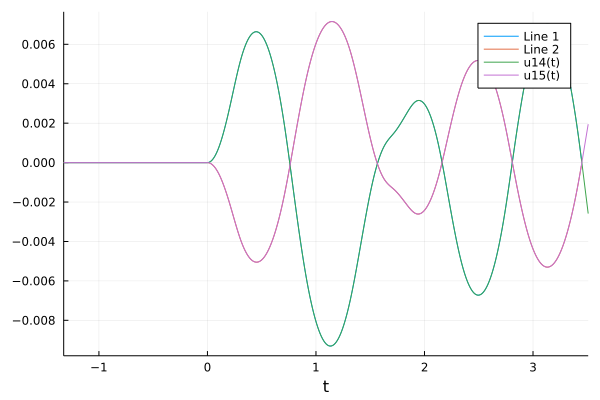

In [9]:
t = -solution.p[1]:0.01:Rocket.BurnTime
Plots.plot(t, reduce(hcat, sample.(Ref(solution.xc), t / Rocket.BurnTime))[14:15, :]', label = ["Line 1" "Line 2"])
Plots.plot!(sol, vars=14:15)

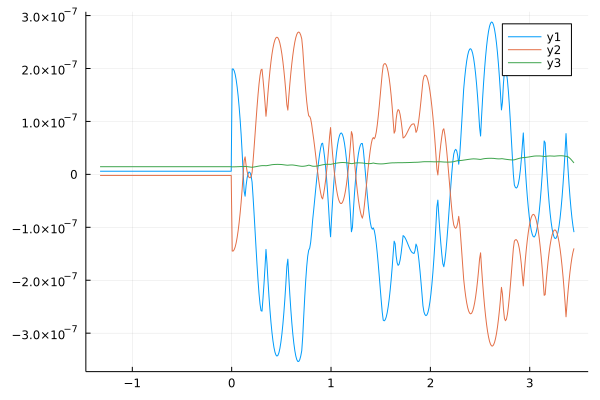

In [10]:
Plots.plot(t, reduce(hcat, sample.(Ref(solution.xc), t / Rocket.BurnTime))[14:16, :]' - reduce(hcat, sol(t).u)[14:16, :]')

In [11]:
using SimulationLogs

In [12]:
include("Aerodynamics.jl")

function f!(dx, x, p, t)
    r = x[1:3]
    height = r[3]
    v = x[4:6]
    quat = x[7:10]
    ω = x[11:13]

    T = p.Control[1:3]
    roll = p.Control[4]

    dx[1:3] = v
    dx[4:6] = p.atmos.gravity(height) + rotate(quat, T) * p.rocket.Acceleration(t)
    dx[7:10] = 1/2 * quatL(quat) * [0; ω]
    dx[11:13] = p.rocket.InertiaTensor \ ([0; 0; -p.rocket.COTToCG(t)] × T * p.rocket.Thrust(t) + [0; 0; roll] - cross(ω, p.rocket.InertiaTensor * ω))

    CalculateAero!(dx[4:6], dx[11:13], p.rocket, p.atmos, p.wind, v, quat, ω, height, t)
end
# test = zeros(4)
function actuator!(integrator)
    rocket, _ = integrator.p
    integrator.p.Control[:] = control(integrator.t, rocket, solution)
    # global test = hcat(test, integrator.p.Control)
end

function actuator(t, Rocket, solution, servoStepSize)
    return control(t - t % servoStepSize, Rocket, solution)
end

function control(t, Rocket, solution)
    if 0 ≤ t ≤ Rocket.BurnTime
        return vcat(sample(solution.xc, t / Rocket.BurnTime)[14:16], sample(solution.uc, t / Rocket.BurnTime)[4])
    else
        return [0., 0., 1., 0.]
    end
end

function mpc(integrator)
    solution = scp_new_problem.solve(:ptr, integrator.u)
end

r_0 = [20; -4; 30];	# position vector, m
v_0 = [4; -3; 0];		# velocity vector, m/s
q_0 = [1; 0; 0; 0];
w_0 = [0; 0; 0]

prob = ODEProblem(f!, float([r_0; v_0; q_0; w_0]), (-solution.p[1], Rocket.BurnTime + 1.0), (rocket=Rocket, atmos=atmos, wind=randn(3) * 5, Control=actuator(-solution.p[1], Rocket, solution, 0.02)))

condition(x,t,integrator) = x[3] # when zero halt integration
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition, nothing, affect!) # when going upwards do nothing

pcb = PeriodicCallback(actuator!, 0.02)
pcb2 = PeriodicCallback(mpc, 0.5)

cbs = CallbackSet(cb, pcb, pcb2)
sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cbs)

println(sol.t[end])
Plots.plot(sol, vars=1:3)

DimensionMismatch: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(13),), b has dims (Base.OneTo(3),), mismatch at 1")

3.4826282790391394


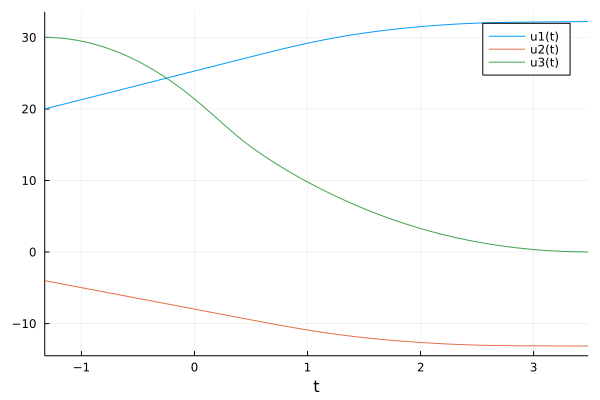

In [13]:
include("Aerodynamics.jl")

function f!(dx, x, p, t)
    r = x[1:3]
    height = r[3]
    v = x[4:6]
    quat = x[7:10]
    ω = x[11:13]

    T = actuator(t, p.rocket, solution, 0.02)[1:3]
    roll = actuator(t, p.rocket, solution, 0.02)[4]

    dx[1:3] = v
    dx[4:6] = p.atmos.gravity(height) + rotate(quat, T) * p.rocket.Acceleration(t)
    dx[7:10] = 1/2 * quatL(quat) * [0; ω]
    dx[11:13] = p.rocket.InertiaTensor \ ([0; 0; -p.rocket.COTToCG(t)] × T * p.rocket.Thrust(t) + [0; 0; roll] - cross(ω, p.rocket.InertiaTensor * ω))

    CalculateAero!(dx[4:6], dx[11:13], p.rocket, p.atmos, p.wind, v, quat, ω, height, t)
end

function actuator(t, Rocket, solution, servoStepSize)
    return control(t - t % servoStepSize, Rocket, solution)
end

function control(t, Rocket, solution)
    if 0 ≤ t ≤ Rocket.BurnTime
        return vcat(sample(solution.xc, t / Rocket.BurnTime)[14:16], sample(solution.uc, t / Rocket.BurnTime)[4])
    else
        return [0., 0., 1., 0.]
    end
end

r_0 = [20; -4; 30];	# position vector, m
v_0 = [4; -3; 0];		# velocity vector, m/s
q_0 = [1; 0; 0; 0];
w_0 = [0; 0; 0]

prob = ODEProblem(f!, float([r_0; v_0; q_0; w_0]), (-solution.p[1], Rocket.BurnTime + 1.0), (rocket=Rocket, atmos=atmos, wind=randn(3) * 5, Control=actuator(-solution.p[1], Rocket, solution, 0.02)))

condition(x,t,integrator) = x[3] # when zero halt integration
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition, nothing, affect!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

println(sol.t[end])
Plots.plot(sol, vars=1:3)